## Preprocessing
* remove stopwords from description
* punctuation marks to spaces
* Remove numbers
* Proper name detection
* Similarity metric
* Make lexicon

## Features
* lexicon
* Amount (discretised)
* Sign (debit/credit)
* Date (weekend/weekday, season?)
* n-grams
* Character n-grams (maybe) to detect shortened words

## Categories
#### Categories I have now
* bank (transfers)
* means of transport
* shopping
* payroll (wages)
* entertainment/leisure/beers
* health/beauty
* education
* other


#### Other potential categories
* household expenses
* taxes and charges


In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
import re
import json

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/billydodds/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [132]:
data = pd.read_csv("administration/CSVData.csv", header=None)
data.columns = ["date", "amount", "description", "balance"]
data['date']  = pd.to_datetime(data['date'], format='%d/%m/%Y')
data = data.astype({'amount':'float', 'balance':'float'})
data = data.drop("balance", axis=1)

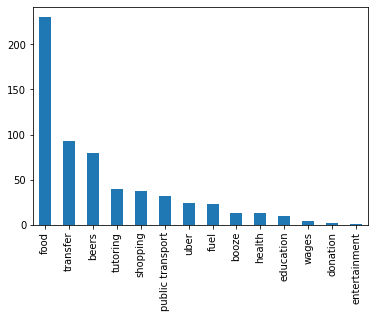

In [133]:
labels = pd.read_csv("administration/CSVData labelled.csv", header=None)
labels.columns = ["description", "category"]

labels.description = labels.description.str.strip()
labels.description = labels.description.str.lower()
data.description = data.description.str.strip()
data.description = data.description.str.lower()

data_labs = data.merge(labels, on='description', how="left")
data_labs.category.value_counts().plot(kind='bar')

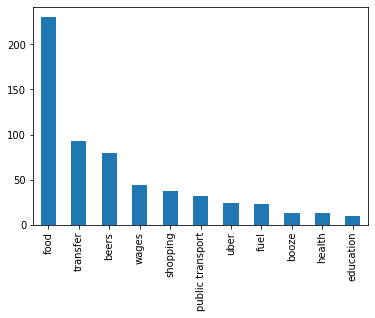

In [134]:
data_labs.category = ["beers" if cat == "entertainment" else cat for cat in data_labs.category]
data_labs.category = ["wages" if cat == "tutoring" else cat for cat in data_labs.category]
data_labs = data_labs[data_labs.category != "donation"]
data_labs.reset_index()
data_labs.category.value_counts().plot(kind='bar')


In [135]:
# data_labs["nom_amount"] = pd.cut(abs(data_labs.amount), bins=[0, 15, 50, 100, 500, np.inf], labels=["low", "low-medium", "medium", "medium-high", "high"], right=False)
data_labs["nom_amount"] = pd.cut(abs(data_labs.amount), bins=[0, 15, 50, 100, 500, np.inf], labels=[1, 2, 3, 4, 5], right=False)
# data_labs["sign"] = ["credit" if amount > 0 else "debit" for amount in data_labs.amount]
data_labs["is_credit"] = [True if amount > 0 else False for amount in data_labs.amount]
# data_labs["weekday"] = data_labs.date.dt.weekday
# data_labs["weekend"] = [True if day >= 4 else False for day in data_labs.weekday]


        

In [136]:
value_dates = []
for desc in data_labs.description:
    if "value date: " in desc:
        val_date = desc.split("value date: ")[1]
        val_date = val_date.strip()
        value_dates.append(val_date)
    else:
        value_dates.append(None)
value_dates = np.array(value_dates)
data_labs["value_date"] = value_dates
data_labs.value_date = pd.to_datetime(data_labs.value_date, format='%d/%m/%Y')

(array([  5.,   0.,  18.,  96.,  80., 100.,  41.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 7 Patch objects>)

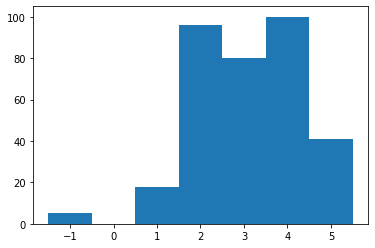

In [137]:
date_diff = data_labs.date - data_labs.value_date
data_labs["date_diff"] = date_diff

date_diff_nonull = date_diff[~date_diff.isnull()].dt.days

plt.hist(date_diff_nonull, bins=7, align="left")


In [138]:
print(np.median(date_diff_nonull))
print(np.mean(date_diff_nonull))
data_labs

3.0
3.1088235294117648


,date,amount,description,category,nom_amount,is_credit,value_date,date_diff
0,2020-06-21,-8.00,mcdonalds coogee coogee nswau,food,1,False,NaT,NaT
1,2020-06-20,-12.90,chargrill charlies lane cove au,food,1,False,NaT,NaT
2,2020-06-20,-10.99,blooms the chemist j nowra ns aus card xx6725 ...,health,1,False,2020-06-18,2 days
3,2020-06-20,-10.00,kangaroo valley gourme kangaroo vall ns aus ca...,food,1,False,2020-06-18,2 days
4,2020-06-20,-38.00,quattro pizzeria berry ns aus card xx6725 valu...,food,2,False,2020-06-18,2 days
5,2020-06-19,100.00,transfer from xx4138 commbank app,transfer,4,True,NaT,NaT
6,2020-06-19,-70.00,bws liquor w1616 newtown au card ...,booze,3,False,NaT,NaT
7,2020-06-18,-11.59,berry iga plus liquo berry au card ...,shopping,1,False,NaT,NaT
8,2020-06-18,93.00,transfer from miss charlotte alice mcgui credi...,transfer,3,True,NaT,NaT
9,2020-06-17,-4.55,mcdonalds albion park albion park nswau,food,1,False,NaT,NaT


In [139]:

# If there is no value date in the description, 
# it is assumed that the date of the record is the date of the transaction.

transaction_date = []
for index, row in data_labs.iterrows():
    if pd.isnull(row.value_date):
        transaction_date.append(row.date)
    else:
        transaction_date.append(row.value_date)
        
data_labs["trans_date"] = transaction_date
data_labs

tr_data = data_labs.drop(["date", "amount", "value_date", "date_diff"], axis=1)
tr_data.columns = ["description", "category", "amount", "is_credit", "date"]
tr_data["weekday"] = tr_data.date.dt.weekday
tr_data["weekend"] = [True if day >= 4 else False for day in tr_data.weekday]
tr_data = tr_data.drop("weekday", axis=1)
tr_data

# print(float(False))

,description,category,amount,is_credit,date,weekend
0,mcdonalds coogee coogee nswau,food,1,False,2020-06-21,True
1,chargrill charlies lane cove au,food,1,False,2020-06-20,True
2,blooms the chemist j nowra ns aus card xx6725 ...,health,1,False,2020-06-18,False
3,kangaroo valley gourme kangaroo vall ns aus ca...,food,1,False,2020-06-18,False
4,quattro pizzeria berry ns aus card xx6725 valu...,food,2,False,2020-06-18,False
5,transfer from xx4138 commbank app,transfer,4,True,2020-06-19,True
6,bws liquor w1616 newtown au card ...,booze,3,False,2020-06-19,True
7,berry iga plus liquo berry au card ...,shopping,1,False,2020-06-18,False
8,transfer from miss charlotte alice mcgui credi...,transfer,3,True,2020-06-18,False
9,mcdonalds albion park albion park nswau,food,1,False,2020-06-17,False


In [140]:
pos_tag("cam.pos coffee new/town ns aus card xx6725 value".split(" "))

blacklist = ['CC', 'CD', 'DT', 'EX', 'IN', 'LS', 'MD', 'TO', 'UH']
blacklist_words = ['card', 'aus']

def clean_chop(string):
    lex = ""
    out = string
    if "value date: " in out:
        out = out.split("value date: ")[0]
    output = []
    out = re.sub(r'\d+', "", out)
    out = re.sub(r'([^a-z ]+)', " ", out)
    out = out.strip().split(" ")
    for word in out:
        if len(word)>2:
            output.append(word)
    output = pos_tag(output)
    for word, code in output:
        if code not in blacklist and word not in blacklist_words:
            wrd = word
            while len(wrd) >= 3:
                lex += wrd + " "
                wrd = wrd[0:-1]
    return lex.strip()


def clean(string):
    lex = ""
    out = string
    if "value date: " in out:
        out = out.split("value date: ")[0]
    output = []
    out = re.sub(r'\d+', "", out)
    out = re.sub(r'([^a-z ]+)', " ", out)
    out = out.strip().split(" ")
    for word in out:
        if len(word)>2:
            output.append(word)
    output = pos_tag(output)
    for word, code in output:
        if code not in blacklist and word not in blacklist_words:
            lex += word + " "
    return lex.strip()



# print(clean("cam.pos coffee new/town ns aus card xx6725 value"))
# print(clean("uber *trip sydney ns aus card"))
# print(clean("liquorland 3638 glebe au aus card xx6725 value.."))
# print(clean("sq *an dail camperdown au aus card xx6725 valu"))


tr_data["desc_lexicon"] = [clean_chop(desc) for desc in tr_data.description]
tr_data["desc_features"] = [clean(desc) for desc in tr_data.description]
tr_data

,description,category,amount,is_credit,date,weekend,desc_lexicon,desc_features
0,mcdonalds coogee coogee nswau,food,1,False,2020-06-21,True,mcdonalds mcdonald mcdonal mcdona mcdon mcdo m...,mcdonalds coogee coogee nswau
1,chargrill charlies lane cove au,food,1,False,2020-06-20,True,chargrill chargril chargri chargr charg char c...,chargrill charlies lane cove
2,blooms the chemist j nowra ns aus card xx6725 ...,health,1,False,2020-06-18,False,blooms bloom bloo blo chemist chemis chemi che...,blooms chemist nowra
3,kangaroo valley gourme kangaroo vall ns aus ca...,food,1,False,2020-06-18,False,kangaroo kangaro kangar kanga kang kan valley ...,kangaroo valley gourme kangaroo vall
4,quattro pizzeria berry ns aus card xx6725 valu...,food,2,False,2020-06-18,False,quattro quattr quatt quat qua pizzeria pizzeri...,quattro pizzeria berry
5,transfer from xx4138 commbank app,transfer,4,True,2020-06-19,True,transfer transfe transf trans tran tra commban...,transfer commbank app
6,bws liquor w1616 newtown au card ...,booze,3,False,2020-06-19,True,bws liquor liquo liqu liq newtown newtow newto...,bws liquor newtown
7,berry iga plus liquo berry au card ...,shopping,1,False,2020-06-18,False,berry berr ber iga liquo liqu liq berry berr ber,berry iga liquo berry
8,transfer from miss charlotte alice mcgui credi...,transfer,3,True,2020-06-18,False,transfer transfe transf trans tran tra miss mi...,transfer miss charlotte alice mcgui credit acc...
9,mcdonalds albion park albion park nswau,food,1,False,2020-06-17,False,mcdonalds mcdonald mcdonal mcdona mcdon mcdo m...,mcdonalds albion park albion park nswau


In [141]:
global_lexicon = {}
for cat in tr_data.category.unique():
    lex = {}
    for index, row in tr_data[tr_data.category == cat].iterrows():
        words = row.desc_lexicon.split(" ")
        for word in words:
            if word not in lex.keys():
                lex[word] = 1
            else:
                lex[word] += 1
    
    # Order the words in descending frequency, 
    # prioritising shorter words by sorting secondarily on decreasing word length.
    words = {k: v for k, v in sorted(lex.items(), key=lambda item: (item[1], 1/len(item[0])), reverse=True)}
    freq = np.array(list(words.values()))
    perc = freq/tr_data[tr_data.category == cat].shape[0]
    
    thresh = 0.1
    features = []
    for word, percent in zip(words.keys(), perc):
        if percent > thresh:
            # tup = (word, percent)
            features.append(word)
    global_lexicon[cat] = features
    print(cat, features)
file = open("administration/lexicon.json", "w")
json.dump(global_lexicon, file)
file.close()


food ['cam', 'syd', 'camp', 'sydn', 'sydne', 'sydney', 'campe', 'camper', 'camperd', 'camperdo', 'camperdow', 'camperdown', 'nsw', 'caf', 'cafe', 'mcd', 'mcdo', 'mcdon', 'mcdona', 'mcdonal', 'mcdonald', 'mcdonalds', 'nswa', 'nswau', 'pty', 'ele', 'elev', 'eleve', 'eleven']
health ['gla', 'glad', 'glade', 'glades', 'gladesv', 'gladesvi', 'gladesvil', 'gladesvill', 'gladesville', 'fun', 'pcp', 'pha', 'den', 'cor', 'try', 'mos', 'rug', 'onl', 'pur', 'bar', 'syd', 'func', 'phar', 'dent', 'corp', 'tryb', 'mosm', 'onli', 'purc', 'barb', 'sydn', 'funct', 'pharm', 'denta', 'corpo', 'trybo', 'mosma', 'onlin', 'purch', 'barbe', 'sydne', 'functi', 'dental', 'corpor', 'tryboo', 'mosman', 'online', 'purcha', 'barber', 'sydney', 'functio', 'corpora', 'trybook', 'function', 'corporat', 'trybooki', 'corporati', 'trybookin', 'corporatio', 'trybooking', 'corporation']
transfer ['tra', 'tran', 'trans', 'transf', 'transfe', 'transfer', 'com', 'comm', 'commb', 'commba', 'commban', 'commbank', 'app', 'cre',

In [142]:
# distance = nltk.edit_distance
def distance(string1, string2):
    return nltk.jaccard_distance(set(string1), set(string2))

def desc_dist(lexicon, desc):
    min_distances = []
    min_dist = np.inf
    for feature in desc.split(" "):
        for lex in lexicon:
            dist = distance(feature, lex)
            if dist < min_dist:
                min_dist = dist
        min_distances.append(min_dist)
    return np.mean(min_distances)



for cat, lexicon in global_lexicon.items():
    tr_data[cat + "_desc_dist"] = [desc_dist(lexicon, desc) for desc in tr_data.desc_features]



In [143]:
# Minimum pairings
tr_data

,description,category,amount,is_credit,date,weekend,desc_lexicon,desc_features,food_desc_dist,health_desc_dist,transfer_desc_dist,booze_desc_dist,shopping_desc_dist,wages_desc_dist,fuel_desc_dist,education_desc_dist,beers_desc_dist,uber_desc_dist,public transport_desc_dist
0,mcdonalds coogee coogee nswau,food,1,False,2020-06-21,True,mcdonalds mcdonald mcdonal mcdona mcdon mcdo m...,mcdonalds coogee coogee nswau,0.000000,0.375000,0.444444,0.093750,0.375000,0.541667,0.425000,0.275000,0.312500,0.666667,0.580357
1,chargrill charlies lane cove au,food,1,False,2020-06-20,True,chargrill chargril chargri chargr charg char c...,chargrill charlies lane cove,0.525000,0.441919,0.555556,0.312500,0.529221,0.285714,0.313889,0.506250,0.511364,0.643750,0.477273
2,blooms the chemist j nowra ns aus card xx6725 ...,health,1,False,2020-06-18,False,blooms bloom bloo blo chemist chemis chemi che...,blooms chemist nowra,0.537037,0.400000,0.500000,0.400000,0.400000,0.589947,0.547619,0.574074,0.583333,0.702381,0.552910
3,kangaroo valley gourme kangaroo vall ns aus ca...,food,1,False,2020-06-18,False,kangaroo kangaro kangar kanga kang kan valley ...,kangaroo valley gourme kangaroo vall,0.453333,0.500000,0.447222,0.520000,0.525000,0.457143,0.453333,0.576190,0.428571,0.651190,0.555556
4,quattro pizzeria berry ns aus card xx6725 valu...,food,2,False,2020-06-18,False,quattro quattr quatt quat qua pizzeria pizzeri...,quattro pizzeria berry,0.575758,0.466667,0.500000,0.375000,0.380952,0.333333,0.508333,0.575758,0.518519,0.561905,0.500000
5,transfer from xx4138 commbank app,transfer,4,True,2020-06-19,True,transfer transfe transf trans tran tra commban...,transfer commbank app,0.458333,0.444444,0.000000,0.518519,0.500000,0.000000,0.565476,0.565476,0.500000,0.428571,0.285714
6,bws liquor w1616 newtown au card ...,booze,3,False,2020-06-19,True,bws liquor liquo liqu liq newtown newtow newto...,bws liquor newtown,0.500000,0.623810,0.680556,0.266667,0.377778,0.485714,0.500000,0.716883,0.597222,0.726984,0.704762
7,berry iga plus liquo berry au card ...,shopping,1,False,2020-06-18,False,berry berr ber iga liquo liqu liq berry berr ber,berry iga liquo berry,0.714286,0.400000,0.500000,0.275000,0.000000,0.585714,0.400000,0.600000,0.525000,0.400000,0.736111
8,transfer from miss charlotte alice mcgui credi...,transfer,3,True,2020-06-18,False,transfer transfe transf trans tran tra miss mi...,transfer miss charlotte alice mcgui credit acc...,0.542208,0.450397,0.000000,0.318651,0.500000,0.000000,0.535714,0.392857,0.410714,0.428571,0.285714
9,mcdonalds albion park albion park nswau,food,1,False,2020-06-17,False,mcdonalds mcdonald mcdonal mcdona mcdon mcdo m...,mcdonalds albion park albion park nswau,0.000000,0.340278,0.444444,0.375000,0.375000,0.598611,0.500000,0.500000,0.500000,0.666667,0.573413


In [144]:
model_data = tr_data.drop(["description", "date", "desc_features", "desc_lexicon"], axis=1)
model_data = model_data[list(model_data.columns[1::])+ ['category']]

# model_data = model_data.drop(list(model_data.columns[3:-1]), axis=1)
model_data

,amount,is_credit,weekend,food_desc_dist,health_desc_dist,transfer_desc_dist,booze_desc_dist,shopping_desc_dist,wages_desc_dist,fuel_desc_dist,education_desc_dist,beers_desc_dist,uber_desc_dist,public transport_desc_dist,category
0,1,False,True,0.000000,0.375000,0.444444,0.093750,0.375000,0.541667,0.425000,0.275000,0.312500,0.666667,0.580357,food
1,1,False,True,0.525000,0.441919,0.555556,0.312500,0.529221,0.285714,0.313889,0.506250,0.511364,0.643750,0.477273,food
2,1,False,False,0.537037,0.400000,0.500000,0.400000,0.400000,0.589947,0.547619,0.574074,0.583333,0.702381,0.552910,health
3,1,False,False,0.453333,0.500000,0.447222,0.520000,0.525000,0.457143,0.453333,0.576190,0.428571,0.651190,0.555556,food
4,2,False,False,0.575758,0.466667,0.500000,0.375000,0.380952,0.333333,0.508333,0.575758,0.518519,0.561905,0.500000,food
5,4,True,True,0.458333,0.444444,0.000000,0.518519,0.500000,0.000000,0.565476,0.565476,0.500000,0.428571,0.285714,transfer
6,3,False,True,0.500000,0.623810,0.680556,0.266667,0.377778,0.485714,0.500000,0.716883,0.597222,0.726984,0.704762,booze
7,1,False,False,0.714286,0.400000,0.500000,0.275000,0.000000,0.585714,0.400000,0.600000,0.525000,0.400000,0.736111,shopping
8,3,True,False,0.542208,0.450397,0.000000,0.318651,0.500000,0.000000,0.535714,0.392857,0.410714,0.428571,0.285714,transfer
9,1,False,False,0.000000,0.340278,0.444444,0.375000,0.375000,0.598611,0.500000,0.500000,0.500000,0.666667,0.573413,food


In [177]:
# Decision Tree
# In-sample accuracy:
model = DecisionTreeClassifier()
# model_data.index = model_data.re

model_data = model_data.reset_index(drop=True)
model_data

X = model_data.drop('category', axis=1)

y = model_data.category
model.fit(X, y)
predictions = model.predict(X)
sum(predictions == y)/len(predictions)

# k-fold cross validation
skf = StratifiedKFold(n_splits=9)
# skf.get_n_splits(X, y)

accuracies = []
for train_index, test_index in skf.split(X, y):
    model = DecisionTreeClassifier()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = sum(predictions == y_test)/len(predictions)
    accuracies.append(acc)

print(np.mean(accuracies))


# X.iloc[[1, 3]]

# model.fit(train.drop('category', axis=1), train.category)
# predictions = model.predict(test.drop('category', axis=1))
# sum(predictions == test.category)/len(predictions)

0.7940003888632811


In [179]:
def yo(x):
    x = x+1
    return x
x = 1
yo(x)
print(x)

1
